In [1]:
import siren

In [2]:
from siren.SIREN_Controller import SIREN_Controller

In [3]:
import os

In [23]:
import pandas as pd
import numpy as np
from MuonSimulationHelpers import get_flux_data

In [12]:
input_file = np.loadtxt("../forward-nu-flux-fit/files/LHC13_EPOSLHC_light_0.txt")
flux_data = get_flux_data("LHC13","EPOSLHC","light")
flux_data.to_csv("Data/SIREN_Input/LHC13_EPOSLHC_light_0.txt",index=False)

In [4]:
# Number of events to inject
events_to_inject = int(9e4)

# Expeirment to run
experiment = "LakeGeneva"

# Define the controller
controller = SIREN_Controller(events_to_inject, experiment)

# Particle to inject
primary_type = siren.dataclasses.Particle.ParticleType.NuMu

cross_section_model = "CSMSDISSplines"

xsfiledir = siren.utilities.get_cross_section_model_path(cross_section_model)

# Cross Section Model
target_type = siren.dataclasses.Particle.ParticleType.Nucleon

DIS_xs = siren.interactions.DISFromSpline(
    os.path.join(xsfiledir, "dsdxdy_nu_CC_iso.fits"),
    os.path.join(xsfiledir, "sigma_nu_CC_iso.fits"),
    [primary_type],
    [target_type], "m"
)

primary_xs = siren.interactions.InteractionCollection(primary_type, [DIS_xs])
controller.SetInteractions(primary_xs)


In [5]:
# Primary distributions
primary_injection_distributions = {}
primary_physical_distributions = {}

primary_external_dist = siren.distributions.PrimaryExternalDistribution("Data/SIREN_Input/LHC13_EPOSLHC_light_0.txt")
primary_injection_distributions["external"] = primary_external_dist


fid_vol = controller.GetFiducialVolume()
position_distribution = siren.distributions.PrimaryBoundedVertexDistribution(fid_vol)
primary_injection_distributions["position"] = position_distribution

# SetProcesses
controller.SetProcesses(
    primary_type, primary_injection_distributions, primary_physical_distributions
)

controller.Initialize()

In [6]:
events = controller.GenerateEvents()

In [7]:
controller.SaveEvents("Data/SIREN_Input/LHC13_EPOSLHC_light_0")

In [8]:
import awkward as ak

In [9]:
data = ak.from_parquet("Data/SIREN_Input/LHC13_EPOSLHC_light_0.parquet")

In [34]:
muon_momenta = np.squeeze(data.secondary_momenta[:,:,0])
hadron_momenta = np.squeeze(data.secondary_momenta[:,:,1])
nu_momenta = np.squeeze(data.primary_momentum)

In [26]:
import matplotlib.pyplot as plt

[]

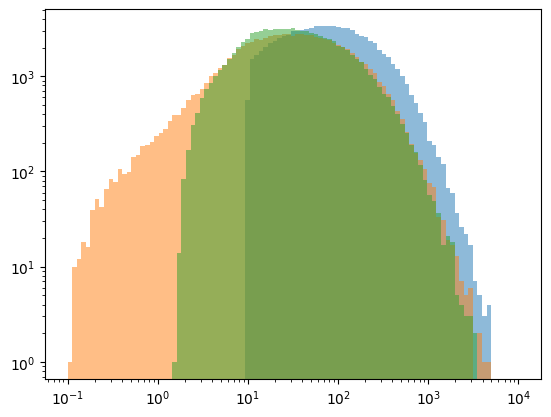

In [35]:
e_bins = np.logspace(-1,4,100)
plt.hist(nu_momenta[:,0],bins=e_bins,alpha=0.5)
plt.hist(muon_momenta[:,0],bins=e_bins,alpha=0.5)
plt.hist(hadron_momenta[:,0],bins=e_bins,alpha=0.5)
plt.loglog()